__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_flat.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

27216


,title,adr,latitude,longitude,priceM,ts
7380,"2-к. квартира, 44,5 м², 3/5 эт.","Севастополь, улица Горпищенко, 18",44.59,33.45,5.80,2022-08-31 17:42:00
14324,"1-к. квартира, 66 м², 3/3 эт.","Севастополь, аллея Защитников 35-й Батареи, д. 11а",44.58,33.51,14.90,2022-09-02 13:04:00
13297,"3-к. квартира, 57,5 м², 1/5 эт.","Севастополь, улица Горпищенко, 56",44.60,33.56,8.30,2022-09-01 14:07:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27216 entries, 0 to 27215
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   avito_id       18608 non-null  float64       
 1   title          27216 non-null  object        
 2   price          27216 non-null  int64         
 3   adr            27216 non-null  object        
 4   description    27216 non-null  object        
 5   obj_name       27216 non-null  object        
 6   ts             27216 non-null  datetime64[ns]
 7   avito_page     18608 non-null  float64       
 8   place          27216 non-null  object        
 9   nrooms         27216 non-null  int64         
 10  floor          27216 non-null  int64         
 11  nfloors        27216 non-null  int64         
 12  area           27216 non-null  float64       
 13  is_studio      27216 non-null  bool          
 14  is_apartment   27216 non-null  bool          
 15  is_part        2721

In [7]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

27216
27216


In [8]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

In [9]:
# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

27216
22342


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
10310,"3-к. квартира, 98 м², 4/5 эт.","Севастополь, улица Николая Музыки, д. 25",44.55,33.52,13.50
14186,"1-к. квартира, 33,2 м², 9/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 1",44.51,33.60,5.81
18099,"1-к. квартира, 25 м², 1/3 эт.","Севастополь, аллея Защитников 35-й Батареи, д. 11а",44.58,33.51,3.61


In [12]:
del df

In [13]:
# gdf[['title','adr','latitude','longitude','priceM','geometry']].explore()

## общая статистика изменение цены

In [14]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   10%   25%   50%   75%   90%    max
nrooms dt                                                                     
1      2022-08-26 1212.00  6.27 1.91 1.59  4.10  5.00  6.00  7.30  8.50  18.50
       2022-08-29 1204.00  6.26 1.91 1.75  4.11  5.00  6.00  7.25  8.50  18.50
       2022-08-31 1195.00  6.36 1.92 1.30  4.20  5.10  6.00  7.50  8.84  18.50
       2022-09-01 1174.00  6.33 1.89 1.30  4.19  5.10  6.00  7.40  8.59  18.50
       2022-09-02  367.00  6.31 2.09 3.65  4.01  4.86  5.81  7.18  9.35  14.90
       2022-09-05  374.00  6.21 2.10 3.10  3.99  4.81  5.58  7.07  9.35  14.90
       2022-09-06  373.00  6.22 2.09 3.15  3.99  4.84  5.63  7.05  9.33  14.90
       2022-09-07  322.00  6.35 2.10 3.10  4.09  4.88  5.81  7.23  9.35  14.90
       2022-09-08 1335.00  5.85 2.49 1.40  3.32  4.15  5.35  7.10  9.03  18.50
       2022-09-12 1217.00  5.83 2.50 1.40  3.25  4.20  5.27  7.00  8.95  18.50
       2022-09-13 1211.00  5.89 2.55 1.40  3.20  4.20  5.37  7.20  9.35  18.50
       2022-09-15 1219.00  5.82 2.43 1.40  3.25  4.24  5.35  7.00  8.90  18.50
2      2022-08-26  949.00  8.82 3.29 2.80  5.80  6.60  8.11 10.24 12.65  36.00
       2022-08-29  946.00  8.87 3.29 2.80  5.88  6.70  8.19 10.40 12.62  36.00
       2022-08-31  935.00  8.84 3.20 2.60  5.80  6.67  8.10 10.33 12.85  35.00
       2022-09-01  959.00  8.90 3.31 2.65  5.80  6.70  8.18 10.50 12.90  36.00
       2022-09-02  113.00  9.68 2.64 4.91  6.37  7.56  9.58 11.60 12.96  15.70
       2022-09-05  133.00  9.81 2.71 4.92  6.42  8.10  9.30 11.50 13.85  15.70
       2022-09-06  189.00  9.74 2.70 4.91  6.33  7.90  9.30 11.60 13.65  15.70
       2022-09-07  130.00  9.79 2.86 4.91  6.23  7.57  9.43 11.87 13.91  15.70
       2022-09-08  694.00  9.67 4.75 3.20  5.90  6.70  8.50 11.32 13.93  49.12
       2022-09-12  609.00  9.46 4.94 3.00  5.46  6.50  8.25 11.00 13.82  49.12
       2022-09-13  605.00  9.41 5.00 3.00  5.50  6.50  8.18 10.80 13.96  49.12
       2022-09-15  629.00  9.34 4.79 3.00  5.65  6.50  8.18 10.80 13.85  49.12
3      2022-08-26  650.00 11.62 6.13 3.50  7.40  8.30 10.30 13.24 16.72 100.00
       2022-08-29  640.00 11.66 6.15 3.85  7.40  8.49 10.33 13.26 16.65 100.00
       2022-08-31  643.00 11.64 6.10 3.85  7.40  8.47 10.30 13.10 17.00 100.00
       2022-09-01  638.00 11.58 6.11 3.85  7.40  8.30 10.21 13.00 16.90 100.00
       2022-09-02   61.00 11.17 1.74 7.73 10.21 10.33 10.35 11.53 13.90  16.64
       2022-09-05   67.00 11.22 1.85 7.73 10.21 10.33 10.35 12.03 14.18  16.64
       2022-09-06   65.00 11.22 1.87 7.73 10.21 10.33 10.34 11.53 14.27  16.64
       2022-09-07   58.00 11.26 1.81 9.20 10.21 10.33 10.35 11.35 14.13  16.64
       2022-09-08  365.00 12.45 6.42 5.00  7.62  9.20 10.35 14.00 18.00  56.52
       2022-09-12  339.00 12.59 6.83 5.00  7.60  9.00 10.35 13.80 18.50  56.52
       2022-09-13  363.00 12.66 6.68 5.00  7.60  9.20 10.50 14.45 18.48  56.52
       2022-09-15  359.00 12.38 6.69 4.70  7.50  9.00 10.35 13.70 17.50  56.52

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

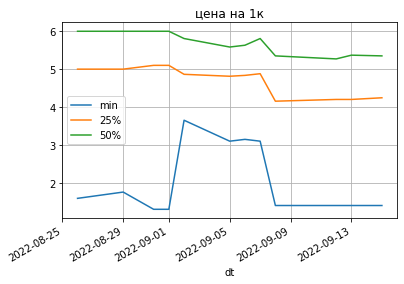

In [15]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

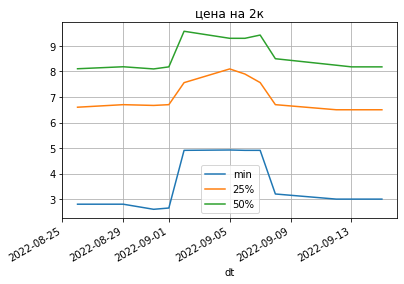

In [16]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

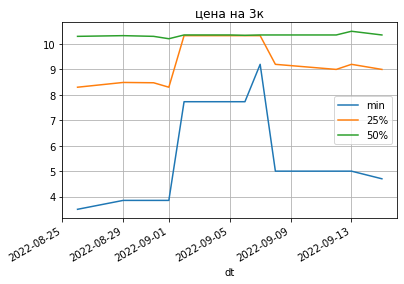

In [17]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

### район поиска

In [18]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([
        { 
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }
    ],crs='EPSG:4326')

In [19]:
frame_all.explore()

### гексагональная сетка

In [36]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

In [37]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

25


,hex_id,geometry
6,862d2d41fffffff,"POLYGON ((33.61556 44.85638, 33.59406 44.82704, 33.62101 44.79829, 33.66945 44.79888, 33.69096 44.82821, 33.66403 44.85697, 33.61556 44.85638))"
2,862d2894fffffff,"POLYGON ((33.56208 44.65198, 33.54065 44.62256, 33.56756 44.59377, 33.61589 44.59440, 33.63733 44.62382, 33.61044 44.65261, 33.56208 44.65198))"


In [22]:
# grid.explore()

In [38]:
ts = '2022-08-01' # ограничиваем дату

In [39]:
# & (gdf['priceM']<15.)
grid_values = ( 
    grid.sjoin( gdf[ (gdf['dt']>ts)  ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [40]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

,area_name,geometry,area_id
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))",0
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))",1
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))",2
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))",3
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))",4
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))",5


In [41]:
# frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  


In [42]:
frames.explore('area_name', legend=True)

In [45]:
area_name=[
'Севастополь, парк 60-летия СССР',
'Севастополь, Хрусталёва/Хрюкина',
]

frame_ = frames[frames['area_name'].isin(area_name)]
grid = cover_grid_hexagonal( frame_.geometry.values[0],cell_size=11 )
print(len(grid))
grid.sample()

202


,hex_id,geometry
128,8b2d289462dcfff,"POLYGON ((33.51514 44.57963, 33.51510 44.57937, 33.51540 44.57921, 33.51574 44.57930, 33.51579 44.57955, 33.51549 44.57972, 33.51514 44.57963))"


In [46]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_in_frame))

22342
993


In [47]:
gdf_in_frame[['title','priceM','adr','geometry']].explore( legend=False)

### изменение цены

In [48]:
stat = gdf_in_frame.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%   75%   90%   max
nrooms dt                                                                
1      2022-08-26 103.00  5.13 2.31 3.10 3.67 3.91 4.22  5.33  8.32 14.90
       2022-08-29 102.00  5.31 2.45 3.10 3.67 3.91 4.24  5.50  8.67 14.90
       2022-08-31  92.00  5.39 2.46 3.10 3.65 3.91 4.40  5.50  8.67 14.25
       2022-09-01  96.00  5.14 2.32 3.10 3.67 3.91 4.17  5.50  8.50 14.25
       2022-09-02  69.00  5.33 2.98 3.65 3.67 3.87 3.99  5.01  9.15 14.90
       2022-09-05  73.00  5.14 2.98 3.10 3.65 3.91 3.99  4.24  8.93 14.90
       2022-09-06  77.00  5.28 2.95 3.15 3.67 3.88 4.02  4.29  8.93 14.90
       2022-09-07  53.00  5.55 3.25 3.10 3.65 3.88 3.95  5.01  9.73 14.90
       2022-09-08  76.00  5.34 3.08 3.10 3.72 3.91 3.99  4.25  9.44 14.90
       2022-09-12  26.00  7.03 4.06 3.10 3.65 3.93 4.24  8.94 13.72 14.90
       2022-09-13  27.00  6.75 3.83 3.10 3.66 3.93 4.24  8.91 13.66 14.90
       2022-09-15  26.00  6.24 3.27 3.10 3.63 3.94 4.24  8.82  9.44 14.90
2      2022-08-26  28.00  7.61 1.54 5.30 6.15 6.38 7.50  8.50  9.49 11.00
       2022-08-29  31.00  7.50 1.52 5.30 5.85 6.35 6.70  8.50  9.50 11.00
       2022-08-31  28.00  7.22 1.22 5.30 6.08 6.38 6.60  8.22  8.74  9.50
       2022-09-01  30.00  7.56 1.51 5.30 6.16 6.50 6.85  8.50  9.50 11.00
3      2022-08-26  15.00 10.75 4.30 7.00 7.35 7.70 8.00 14.40 17.16 19.00
       2022-08-29  15.00 10.78 4.28 7.00 7.35 7.65 8.30 14.40 17.16 19.00
       2022-08-31  12.00 10.79 4.44 7.00 7.28 7.57 8.22 14.20 17.68 19.00
       2022-09-01  14.00 10.93 4.41 7.00 7.33 7.60 8.22 14.60 17.37 19.00

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

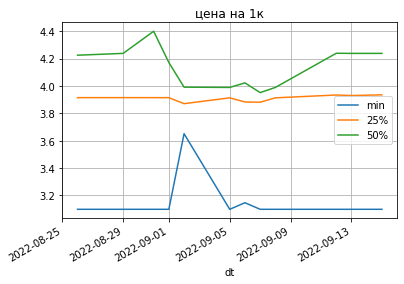

In [49]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

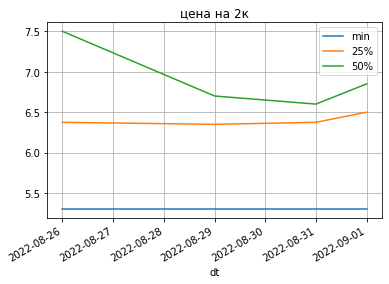

In [50]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

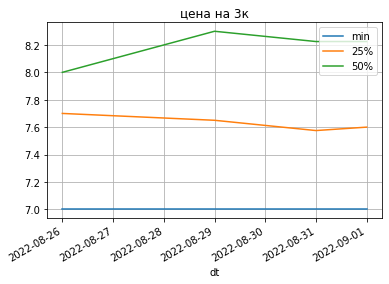

In [51]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

### гексагональная сетка

In [59]:
# import h3
    
# def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
#     polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
#     hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
#     return gpd.GeoDataFrame(
#         { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
#         crs=crs, 
#     )

In [60]:
area_name=['Севастополь, район Острякова']
frame_ = frames[frames['area_name'].isin(area_name)]
grid = cover_grid_hexagonal( frame_.geometry.values[0],cell_size=11 )
print(len(grid))
grid.sample()

2652


,hex_id,geometry
2403,8b2d289404c1fff,"POLYGON ((33.52460 44.58477, 33.52456 44.58452, 33.52485 44.58435, 33.52520 44.58444, 33.52525 44.58470, 33.52495 44.58486, 33.52460 44.58477))"


In [67]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
6,892d289425bffff,"POLYGON ((33.52752 44.56288, 33.52719 44.56109, 33.52928 44.55993, 33.53169 44.56056, 33.53201 44.56235, 33.52993 44.56351, 33.52752 44.56288))"
4,892d2894053ffff,"POLYGON ((33.51344 44.58649, 33.51311 44.58470, 33.51520 44.58354, 33.51761 44.58417, 33.51793 44.58596, 33.51585 44.58712, 33.51344 44.58649))"


### медиана актуальной цены

In [68]:
ts = '2022-08-01' # ограничиваем дату

In [69]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [ ]:
### количество предложений

In [ ]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

In [ ]:
# # количество предложений
# from folium import Map
# from folium.plugins import HeatMap

# start_pos = (44.578330, 33.516509)

# Map(
#     location=start_pos,
#     zoom_start=15,
#     # width=500,
#     #height=2000,
# ).add_child( 
#     HeatMap( 
#         gdf[ gdf['dt']>ts ]
#         .sjoin(frames,how='inner',predicate='within')[['latitude','longitude',]],
#         #radius=10.,
#         #min_opacity=3. 
#     )
# )


In [ ]:
# import folium

# # Create a map
# my_map = folium.Map(location=start_pos, zoom_start=14,)

# # Add the data
# folium.Choropleth(
#     name='choropleth',
#     geo_data=grid,
#     data=grid_values,
#     columns=['hex_id','priceM',],
#     key_on='feature.properties.hex_id',
#     fill_color='YlOrRd',
#     fill_opacity=.7,
#     line_opacity=.2,
#     legend_name='priceM median'
# ).add_to(my_map)
# my_map

In [ ]:
#grid.merge(grid_values).explode(
    #'priceM', 
    #alpha=.5,
    #edgecolors='blue',
    # cmap='rainbow',
    #figsize=(31,31), 
    #legend=True, 
#)

# ax.set(title='медиана цены (в млн.руб.)')

# ctx.add_basemap( 
#     ax,
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )


# frid.explore('area_name', legend=True)